# Week 5 Problem 1

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

7. **If your code does not pass the unit tests, it will not pass the autograder.**

# Due Date: 6 PM, February 19, 2018

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import RobustScaler, Imputer

from sklearn.gaussian_process import  GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from nose.tools import assert_equal, assert_true, assert_false
import numpy.testing as npt

import warnings
warnings.filterwarnings("ignore")

The cell below reads in a simulated dataset where y(labels) are a unknown function of a, b, and c.

In [2]:
df = pd.read_csv('/home/data_scientist/data/misc/sim.data')
df.head()

,a,b,c,y
0,0.004539,0.818678,194.381891,0
1,0.001367,0.243724,245.378577,0
2,1.579454,0.465842,849.943583,0
3,7.189778,0.456895,129.707932,0
4,97.743634,0.319419,120.998294,1


### Problem 1.1

For Problem 1.1 complete the function *f_eng* performing a 80/20 split on the training/testing features and labels. Fit a RobustScaler on the training features and transform the training and testing features. Where appliciable set the random_state argument to *999*. Return in this order: the transformed training features, training labels, transformed testing features, and testing labels. 

In [3]:
def f_eng(data):
    '''
    Splits the training the data and scales the training and testing features
    
    Parameters
    ----------
    data: dataframe containing simulated dataset.
    
    Returns
    -------
    Training features as a multi dimensional numpy array (contains 80% of the features)
    Testing features as a multi dimensional numpy array (contains 20% of the features)
    Training labels as pandas series (contains 80% of the labels)
    Testing labels as pandas series (contains 20% of the labels)
    
    '''
    # YOUR CODE HERE
    x_train, x_test, y_train, y_test = \
        train_test_split(data[['a','b','c']], data['y'], test_size = 0.2, random_state=999)
        
    rc = RobustScaler()
    tfx_train = rc.fit_transform(x_train)
    tfx_test = rc.transform(x_test)
    
    
    return tfx_train, y_train, tfx_test, y_test

In [4]:
X_train, y_train, X_test, y_test = f_eng(df.copy())

assert_equal(type(X_train), np.ndarray)
assert_equal(type(X_test), np.ndarray)

assert_equal(type(y_train), pd.core.series.Series)
assert_equal(type(y_test), pd.core.series.Series)

assert_equal(len(X_train), 800, msg='Make sure that performed a 80/20 split on the training and testing set')
assert_equal(len(y_train), 800, msg='Make sure that performed a 80/20 split on the training and testing set')


npt.assert_almost_equal(X_test[0:10], [[-0.30738115403404553, -0.9736985887996362, -0.49101207865721125], [0.18488952387724725, 0.03189822187579699, 0.8034181154818177], [-0.2198828359426681, 0.3028030199063013, 0.8448490192685679], [-0.1433424985516722, -0.011974164525011167, -0.12831623314094662], [0.09892255871589173, -0.8613137137863287, 0.13219278852677604], [-0.312907980172404, 0.9049807671626223, 1.0237472568184407], [0.8872733278385387, 0.5737690433939666, -0.4839982999236612], [0.43514883771829216, 1.0018458848881164, -0.49359000079927745], [0.08946178277685655, 0.6132921249115915, 0.7152472385801251], [0.9151026455050681, 0.07884286112089098, -0.3973694534680506]], decimal=2)
npt.assert_almost_equal(X_train[345:355], [[-0.3139239995672711, 0.8450084840904671, -0.06351279246792367], [-0.1487563778794215, -0.5104392475039827, -0.0528450006168689], [-0.19904502938519728, -0.8087579296249421, 1.148338814039014], [-0.09315677202225736, -0.2352769528032403, -0.44881999956456353], [-0.2411588708452692, -0.5054923224648885, 0.18491364134755], [-0.25026611398236226, -0.26454867151904576, 1.5482613893681398], [-0.3061110733202404, 0.47425884363241466, -0.09892128734229258], [-0.30962370002167466, -0.7524807869313633, 0.6640450283476379], [-0.2851410690135015, -0.01612153252307675, 1.0374926446256747], [0.10280334279756671, -0.6158793579748008, 0.32803827308069755]], decimal=2)

assert_equal(y_train[0:10].tolist(), [0, 0, 1, 1, 0, 2, 1, 2, 1, 2])
assert_equal(y_test[100:120].tolist(), [1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2, 1, 2, 0, 2])


### Problem 1.2
For Problem 1.2 finish writing the function *l_curve* by generating a learning curve with the model passed into *l_curve, training features/labels, a StratifiedKFold cross validator with *n_splits*, and training sizes over 10 evenly spaced numbers on an interval of .1 to 1. Your function should return *in this order* the training sizes, training scores, and validation scores.

In [5]:
def l_curve(model, X_train, y_train, n_splits=3):
    '''
    generates learning curves of a model
    
    Parameters
    ----------
    model - sklearn estimator
    X_train - training features
    y_train - training labels
    n_splits - number of splits to perform
    
    Returns
    -------
    training sizes - number of training examples used to generate the learning curve (numpy array)
    training scores - Scores on the training set (multi dimensional numpy array)
    validation scores - Scores on the validation set (multi dimensional numpy array)
    '''
    # YOUR CODE HERE
    skf = StratifiedKFold(n_splits=n_splits, random_state=0)
    tr_size = np.linspace(0.1,1,10)
    tr_sizes, tr_score, v_score = \
        learning_curve(model, X_train, y_train, cv=skf, train_sizes=tr_size)
    
    
    
    return tr_sizes, tr_score, v_score
train_sizes, train_scores, val_scores = l_curve(GaussianNB(), X_train, y_train, n_splits=6)
train_scores.mean(axis=1)

array([ 0.83838384,  0.85964912,  0.83919598,  0.84022556,  0.83935743,
        0.84168755,  0.82043011,  0.82236842,  0.82274247,  0.82030075])

In [6]:
train_sizes, train_scores, val_scores = l_curve(GaussianNB(), X_train, y_train, n_splits=6)

assert_equal(train_sizes.tolist(), [66, 133, 199, 266, 332, 399, 465, 532, 598, 665])
npt.assert_almost_equal(train_scores, [[0.8636363636363636, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334], [0.8270676691729323, 0.8421052631578947, 0.8721804511278195, 0.8721804511278195, 0.8721804511278195, 0.8721804511278195], [0.8140703517587939, 0.8442211055276382, 0.8442211055276382, 0.8442211055276382, 0.8442211055276382, 0.8442211055276382], [0.8157894736842105, 0.8571428571428571, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947, 0.8421052631578947], [0.8313253012048193, 0.8554216867469879, 0.8463855421686747, 0.8343373493975904, 0.8343373493975904, 0.8343373493975904], [0.8421052631578947, 0.8571428571428571, 0.8446115288220551, 0.8370927318295739, 0.8345864661654135, 0.8345864661654135], [0.8064516129032258, 0.8258064516129032, 0.8172043010752689, 0.8086021505376344, 0.832258064516129, 0.832258064516129], [0.8045112781954887, 0.8233082706766918, 0.8195488721804511, 0.8101503759398496, 0.8383458646616542, 0.8383458646616542], [0.8177257525083612, 0.8294314381270903, 0.8193979933110368, 0.8177257525083612, 0.8344481605351171, 0.8177257525083612], [0.8135338345864662, 0.8270676691729323, 0.8180451127819549, 0.8135338345864662, 0.8315789473684211, 0.8180451127819549]], decimal=2)
npt.assert_almost_equal(val_scores, [[0.7703703703703704, 0.7777777777777778, 0.8059701492537313, 0.8134328358208955, 0.816793893129771, 0.7938931297709924], [0.8148148148148148, 0.8444444444444444, 0.8656716417910447, 0.8283582089552238, 0.8320610687022901, 0.8320610687022901], [0.7925925925925926, 0.8222222222222222, 0.835820895522388, 0.8134328358208955, 0.7786259541984732, 0.8396946564885496], [0.7925925925925926, 0.7851851851851852, 0.8582089552238806, 0.8208955223880597, 0.7786259541984732, 0.8320610687022901], [0.8148148148148148, 0.8, 0.8582089552238806, 0.8134328358208955, 0.7709923664122137, 0.8320610687022901], [0.8148148148148148, 0.8074074074074075, 0.8656716417910447, 0.8208955223880597, 0.7786259541984732, 0.8320610687022901], [0.8148148148148148, 0.8074074074074075, 0.8656716417910447, 0.8208955223880597, 0.7709923664122137, 0.8320610687022901], [0.8148148148148148, 0.7925925925925926, 0.8432835820895522, 0.835820895522388, 0.7709923664122137, 0.8320610687022901], [0.8222222222222222, 0.7851851851851852, 0.8507462686567164, 0.8283582089552238, 0.7862595419847328, 0.8320610687022901], [0.8222222222222222, 0.7851851851851852, 0.8432835820895522, 0.8283582089552238, 0.7786259541984732, 0.8320610687022901]], decimal=2)


### Problem 1.3
For Problem 1.3 complete the function *plot* creating a plotting learning curves by:
- creating a figure and axes object using [subplots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html) from matplotlib
- take the mean of each column for the training scores and validation scores
- uses the plot function from the axes object to plot *(in this order)*:
    - the number of training examples used to generate the learning curve and the mean of the training scores and
    - the number of training examples used to generate the learning curve and the mean of the validation scores
- title your plot and label the x and y axis of your plot
- lastly return the axes object

If done correctly your plot should look *similar* to the graph below:
![Imgur](https://i.imgur.com/NHELtT2.png)

In [13]:
def plot(train_sizes, train_scores, val_scores):
    '''
    plots learning curve
    
    Parameters
    ----------
    train_sizes - number of training examples used to generate the learning curve (numpy array)
    train_scores - Scores on the training set (multi dimensional numpy array)
    val_scores - Scores on the validation set (multi dimensional numpy array)
    
    Returns
    -------
    Axes object
    '''
    # YOUR CODE HERE
    fig, ax = plt.subplots(figsize=(8,5))
    mean_vc = val_scores.mean(axis=1)
    mean_ts = train_scores.mean(axis=1)
    
    ax.plot(train_sizes, mean_ts, label="Training Score",lw=2, marker='p',color='Red')
    ax.plot(train_sizes, mean_vc, label ='Cross-validation Score', lw=2, marker='p',color='Green')
    
    ax.set(title='Learning Curve', 
           xlabel='Training Examples', ylabel='Scores')
    
    ax.legend(loc=1, borderaxespad=1.5)
    
    return ax

ValueError: Unrecognized marker style c

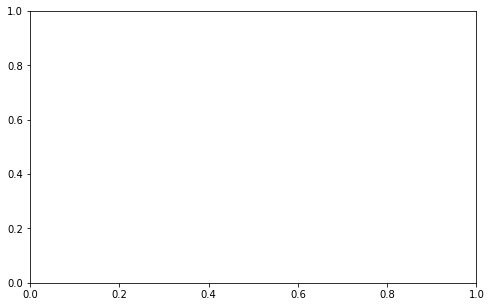

In [14]:
ax = plot(train_sizes, train_scores, val_scores)

assert_true(isinstance(ax, mpl.axes._subplots.Axes), msg='return an axes object')
assert_false(ax.get_title() == '', msg='Set Your title')
assert_false(ax.get_ylabel() == '', msg='Label the y axis')
assert_false(ax.get_xlabel() == '', msg='Label the x axis')

npt.assert_equal(ax.lines[0].get_xdata(), [66, 133, 199, 266, 332, 399, 465, 532, 598, 665])
npt.assert_almost_equal(ax.lines[0].get_ydata(), [0.8383838383838383, 0.8596491228070176, 0.8391959798994976, 0.8402255639097743, 0.8393574297188756, 0.8416875522138679, 0.8204301075268817, 0.8223684210526315, 0.8227424749163879, 0.8203007518796993], decimal=2, err_msg='Make sure you plot the mean training score first. Make sure that you took the mean of the column for the training scores')
npt.assert_almost_equal(ax.lines[1].get_ydata(), [0.7963730260205898, 0.8362352079016847, 0.8137315261408534, 0.811261546381747, 0.8149183401623493, 0.8199127348836818, 0.8186404702526384, 0.814927553355642, 0.8174720826177285, 0.8149560368921579], decimal=2, err_msg="Make sure you plot the mean testing score second. Make sure that you took the mean of the column for the testing scores")
